Note this must be run in env mypython3 in Python3 (i.e. activate environment as below before running)

conda activate mypython3


Hypothesis:

An acceleration of the water cycle under climate climate change means 'the wet areas get wetter, the dry get dryer' (Held and Soden, 2006 https://doi.org/10.1175/JCLI3990.1
). This will shift CO2 uptake capacity from the high to low-latitudes through alkalinity concentration/dilution. The wet areas (high latitudes) tend to be where anthropogenic carbon is taken into the interior ocean, so a shift in uptake towards the dry areas (STGs etc), will result in this carbon increasingly mainly sitting in the mixed layer rather than being taken into the interior (in a relative sense), compromising the long-term ocean C. sink.

There is an argument that climate models underestimate the intensification of the water cycle (they underestimate observed change Durack et al., 2012, DOI: 10.1126/science.1212222), I need to understand the debate about this (e.g. Helm et al., 2010, https://doi.org/10.1029/2010GL044222) better, if true, this means models may may be biased high in terms of ocean carbon storage.

I start by looking at this in a back of the envelope way, then using UKESM preindustrial climatology look at this spatially.


In [161]:
%load_ext autoreload
%autoreload 2


import cartopy.crs as ccrs
import cartopy.feature as cfeature
import iris
import numpy as np
from matplotlib import pyplot as plt
import iris.quickplot as qplt
from PyCO2SYS import CO2SYS
import PyCO2SYS as pyco2
#https://pyco2sys.readthedocs.io/en/latest/co2sys_nd/
# from PyCO2SYS.api import CO2SYS_wrap as co2sys
import iris.coord_categorisation
import matplotlib.gridspec as gridspec
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import iris.plot as iplt
from tqdm import tqdm
import math
import iris.coord_categorisation
import pickle
import bz2
import _pickle as cPickle

Pa_to_uatm = ((1.0/0.9869e-1))

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [162]:
# Saves the "data" with the "title" and adds the .pickle
def compressed_pickle(title, data):
    with bz2.BZ2File(title + '.pbz2', 'w') as f: 
        cPickle.dump(data, f)
        

def decompress_pickle(file):
    data = bz2.BZ2File(file, 'rb')
    data = cPickle.load(data)
    return data

def extract_and_avg_yr_range(cube,start_year,end_year):
    try:
        iris.coord_categorisation.add_year(cube, 'time', name='year')
    except:
        pass
    loc = np.squeeze(np.where((cube.coord('year').points >= start_year) & (cube.coord('year').points <= end_year)))
    return cube[loc].collapsed('time',iris.analysis.MEAN)

def extract_range(cube,start_year,end_year):
    try:
        iris.coord_categorisation.add_year(cube, 'time', name='year')
    except:
        pass
    loc = np.squeeze(np.where((cube.coord('year').points >= start_year) & (cube.coord('year').points <= end_year)))
    return cube[loc]

def prepare_cmip_for_co2sys(cube):
    cube_data = cube.data.data
    cube_data[np.where(cube.data.mask)] = np.nan
    return cube_data


def area_avg(cube):
    try:
        cube.coord('latitude').guess_bounds()
    except:
        pass
    try:
        cube.coord('longitude').guess_bounds()
    except:
        pass
    grid_areas = iris.analysis.cartography.area_weights(cube)
    return cube.collapsed(['longitude', 'latitude'],iris.analysis.MEAN, weights=grid_areas)


def extract_region(cube,lon_west,lon_east,lat_south,lat_north):
    cube_region_tmp = cube.intersection(longitude=(lon_west, lon_east))
    return cube_region_tmp.intersection(latitude=(lat_south,lat_north))


def add_year_coord(cube):
    try:
        iris.coord_categorisation.add_year(cube, 'time', name='year')
    except:
        pass
    return cube

def sort_years(cube):
    my_sort = np.argsort(cube.coord('year').points)
    return cube[my_sort,:,:]


def monthly_to_annual(in_cube):
    iris.coord_categorisation.add_year(in_cube, 'time',name='year')
    return in_cube.aggregated_by(['year'],iris.analysis.MEAN)

In [175]:
# 360x180 ann_mean regridded files in Downloads, copied from $groupserv:/data/BatCaveNAS/ph290/cmip6/regridded/alk_analysis/ produced with /data/BatCaveNAS/ph290/cmip6/merge_regrid_and_annual_mean.py

# Read in the data

directory = '/Users/ph290/Downloads/'

model = 'UKESM1-0-LL'
file6 = directory+model+'_tas_ssp585_r1i1p1f2_gn_regridded.nc'
c_tas = monthly_to_annual(iris.load_cube(file6))
c_tas_data = c_tas.data.data
file8 = directory+'co2mass_Amon_'+model+'_ssp585_r1i1p1f2_gm.nc'
c_co2mass = monthly_to_annual(iris.load_cube(file8))
try:
    iris.coord_categorisation.add_year(c_co2mass, 'time', name='year')
except:
    pass
years = c_co2mass.coord('year').points
# Note, because I merged with select rather than mergetime the order had to be resolved
sort_index = np.argsort(years)
years2 = years[sort_index]
c_co2mass = c_co2mass[sort_index]
locs = np.where((years2 >= 2015) & (years2 <= 2099))
c_co2mass = c_co2mass[locs]
c_co2mass_data_timeseries = c_co2mass.data.data
c_co2mass_data_tmp = np.tile(c_co2mass_data_timeseries, (np.shape(c_tas_data)[1],np.shape(c_tas_data)[2],1))
c_co2mass_data = np.moveaxis(c_co2mass_data_tmp,2,0)

# model = 'UKESM1-0-LL'
models = ['CanESM5','IPSL-CM6A-LR','CNRM-ESM2-1','UKESM1-0-LL','ACCESS-ESM1-5','CESM2-WACCM','MIROC-ES2L','MPI-ESM1-2-HR','MPI-ESM1-2-LR']
cubes = {}

for model in models:
    
    cubes[model]={}

    file1 = directory+model+'_tos_ssp585_r1i1p1f?_gn_regridded.nc'
    file2 = directory+model+'_sos_ssp585_r1i1p1f?_gn_regridded.nc'
    file3 = directory+model+'_dissic_ssp585_r1i1p1f?_gn_regridded.nc'
    file4 = directory+model+'_talk_ssp585_r1i1p1f?_gn_regridded.nc'
    file5 = directory+model+'_spco2_ssp585_r1i1p1f?_gn_regridded.nc'
    file6 = directory+model+'_tas_ssp585_r1i1p1f?_gn_regridded.nc'
    file7 = directory+model+'_psl_ssp585_r1i1p1f?_gn_regridded.nc'


    c_tos = monthly_to_annual(iris.load_cube(file1))
    c_sos = monthly_to_annual(iris.load_cube(file2))
    c_dissic = monthly_to_annual(iris.load_cube(file3))
    try:
        c_dissic = c_dissic.collapsed('depth',iris.analysis.MEAN)
    except:
        try:
            c_dissic = c_dissic.collapsed('lev',iris.analysis.MEAN)
        except:
            try:
                c_dissic = c_dissic.collapsed('Vertical T levels',iris.analysis.MEAN)
            except:
                c_dissic = c_dissic.collapsed('ocean sigma over z coordinate',iris.analysis.MEAN)
    c_talk = monthly_to_annual(iris.load_cube(file4))
    try:
        c_talk = c_talk.collapsed('depth',iris.analysis.MEAN)
    except:
        try:
            c_talk = c_talk.collapsed('lev',iris.analysis.MEAN)
        except:
            try:
                c_talk = c_talk.collapsed('Vertical T levels',iris.analysis.MEAN)
            except:
                c_talk = c_talk.collapsed('ocean sigma over z coordinate',iris.analysis.MEAN)
    
    cubes[model]['tos'] = c_tos
    cubes[model]['sos'] = c_sos
    cubes[model]['dissic'] = c_dissic
    cubes[model]['talk'] = c_talk
    
    try:
        c_spco2 = monthly_to_annual(iris.load_cube(file5))
        cubes[model]['spco2'] = c_spco2
    except:
        pass
    try:
        c_tas = monthly_to_annual(iris.load_cube(file6))
        cubes[model]['tas'] = c_tas
    except:
        pass
    try:
        c_psl = monthly_to_annual(iris.load_cube(file7))
        cubes[model]['psl'] = c_psl
    except:
        pass



    
    
    

# for model in models:

#     c_tos_data = c_tos.data.data
#     c_sos_data = c_sos.data.data
#     c_dissic_data = c_dissic.data.data
#     c_talk_data = c_talk.data.data
#     c_spco2_data = c_spco2.data.data

#     c_tas_data = c_tas.data.data
#     c_psl_data = c_psl.data.data
    

/Users/ph290/miniconda2/envs/mypython3/lib/python3.8/site-packages/iris/fileformats/cf.py:803: UserWarning: Missing CF-netCDF measure variable 'areacella', referenced by netCDF variable 'tas'
  warnings.warn(message % (variable_name, nc_var_name))
/Users/ph290/miniconda2/envs/mypython3/lib/python3.8/site-packages/iris/fileformats/_pyke_rules/compiled_krb/fc_rules_cf_fc.py:2341: UserWarning: Failed to create 'time' dimension coordinate: The 'time' DimCoord points array must be strictly monotonic.
Gracefully creating 'time' auxiliary coordinate instead.
  warnings.warn(msg.format(name=str(cf_coord_var.cf_name),
/Users/ph290/miniconda2/envs/mypython3/lib/python3.8/site-packages/iris/fileformats/cf.py:803: UserWarning: Missing CF-netCDF measure variable 'areacello', referenced by netCDF variable 'tos'
  warnings.warn(message % (variable_name, nc_var_name))
/Users/ph290/miniconda2/envs/mypython3/lib/python3.8/site-packages/iris/fileformats/cf.py:803: UserWarning: Missing CF-netCDF measure v

In [181]:
variables = ['sos','tos','dissic','talk','spco2','tas','psl']

for model in models:
#     print(model)
    for var in variables:
#         print(var)
        if var in list(cubes[model]):
            cube = cubes[model][var]
            try:
                iris.coord_categorisation.add_year(cube, 'time', name='year')
            except:
                pass
            years = cube.coord('year').points
            # Note, because I merged with select rather than mergetime the order had to be resolved
            sort_index = np.argsort(years)
            years2 = years[sort_index]
            cubes[model][var] = cubes[model][var][sort_index]
            #some variables stop in 2099, some in 211, so have restricted to 2099 
            locs = np.where((years2 >= 2015) & (years2 <= 2099))
            cubes[model][var] = cubes[model][var][locs]

#     cubes[model]['sos'] = c_sos
#     cubes[model]['dissic'] = c_dissic
#     cubes[model]['talk'] = c_talk
#     cubes[model]['spco2'] = c_spco2
#     cubes[model]['tas'] = c_tas
#     cubes[model]['psl'] = c_psl



In [182]:
def hold_constant(c_data):
    return np.tile(np.mean(c_data[0:20,:,:],axis=0), (np.shape(c_data)[0],1,1))

def calculate_DIC(c_talk,fCO2,c_sos,c_tos,c_dissic,variables_to_hold_constant):
    #variables_to_hold_constant = [1,2,3,4] c_talk,fCO2,c_sos,c_tos
    c_tos_data = c_tos.data.data
    c_sos_data = c_sos.data.data
    c_dissic_data = c_dissic.data.data
    c_talk_data = c_talk.data.data
    if 1 in variables_to_hold_constant:
        c_talk_data = hold_constant(c_talk_data)
    if 2 in variables_to_hold_constant:
        fCO2 = hold_constant(fCO2)
    if 3 in variables_to_hold_constant:
        c_sos_data = hold_constant(c_sos_data)
    if 4 in variables_to_hold_constant:
        c_tos_data = hold_constant(c_tos_data)
    # https://pyco2sys.readthedocs.io/en/latest/co2sys_nd/#arguments
    par1type = 1  # The first parameter supplied is of type "1", which is "alkalinity"
    par1 = c_talk_data * 1.0e3  # value of the first parameter
    par2type = 5  # The first parameter supplied is of type "1", which is "DIC"
    par2 = fCO2
    # ^ value of the second parameter, which is a long vector of different DIC's!
    sal = c_sos_data # Salinity of the sample
    tempin = c_tos_data  # Temperature at input conditions
    presin = 0  # Pressure    at input conditions
    tempout = 0  # Temperature at output conditions - doesn't matter in this example
    presout = 0  # Pressure    at output conditions - doesn't matter in this example
    sil = 0  # Concentration of silicate  in the sample (in umol/kg)
    po4 = 0  # Concentration of phosphate in the sample (in umol/kg)
    pHscale = 1  # pH scale at which the input pH is reported ("1" means "Total Scale")  - doesn't matter in this example
    k1k2c = 4  # Choice of H2CO3 and HCO3- dissociation constants K1 and K2 ("4" means "Mehrbach refit")
    kso4c = 1  # Choice of HSO4- dissociation constants KSO4 ("1" means "Dickson")
    # Do the calculation. See CO2SYS's help for syntax and output format
    CO2dict =  CO2SYS(par1,par2,par1type,par2type,sal,tempin,tempout,presin,presout,sil,po4,pHscale,k1k2c,kso4c)
    c_dissic_data_out = np.reshape(CO2dict['TCO2'],np.shape(c_talk_data))
    c_dissic_out = c_dissic.copy()
    c_dissic_out.data = c_dissic_data_out
    return c_dissic_out


def total_atm_co2_mass_to_ppmv(total_atm_co2_mass):
    # mole fraction is expressed as parts per million (ppm).
    # For example, CO2 concentration of 365 ppmv is 365x10-6 mol/mol i.e. a mole fraction of 365x10-6
    mass_of_atmopshere = 5.1480e18
    molar_mass_co2 = 44.0095
    avg_molar_mass_dry_air = 28.97
    atm_co2_ppmv = ((total_atm_co2_mass/mass_of_atmopshere)/(molar_mass_co2/avg_molar_mass_dry_air))*1.0e6
    return atm_co2_ppmv

# atm_co2_ppmv = total_atm_co2_mass_to_ppmv(total_atm_co2_mass)

# Fugacity of CO2 in air
# https://cdiac.ess-dive.lbl.gov/ftp/cdiac74/sop24.pdf

# T = 298.15 #K
# p = 101325.0 # Pa (1 atm) ;
# xCO2 = 350.0 #atmospheric ppmv 

def fugacity_of_CO2_in_air(T,p,xCO2):
    # output in uatm
    # https://cdiac.ess-dive.lbl.gov/ftp/cdiac74/sop24.pdf
    # T = e.g. 298.15 #K
    # p = e.g. 101325.0 # Pa (1 atm) ;
    # xCO2 = e.g. 350.0 #atmospheric CO2 dry air mole fraction
    BT = -1636.75 + 12.0408 * (T) - 3.27957e-2 * np.power(T,2) + 3.16528e-5* np.power(T,3) #cm3·mol–1 virial coefficient for the pure CO2
    delta_CO2air = 57.7 - 0.118 * (T)  # (where 273 < (T/K) < 313) Virial coefficient of carbon dioxide in air, cm3·mol–1
    R = 8.31451 # gas constant m3⋅Pa⋅K−1⋅mol−1
    fCO2 = (xCO2 * 1.0e-6) * p * np.exp((((BT * 1.0e-6) + (2 * np.power((1 - (xCO2 * 1.0e-6)),2)) * (delta_CO2air * 1.0e-6)) * p ) / (R * T))
    return fCO2/(101325.0e-6) # convert from Pa to uatm.

# fCO2 = fugacity_of_CO2_in_air(T,p,xCO2)

In [183]:
xCO2 = total_atm_co2_mass_to_ppmv(c_co2mass_data)
fCO2 = fugacity_of_CO2_in_air(cubes['UKESM1-0-LL']['tas'].data.data,cubes['UKESM1-0-LL']['psl'].data.data,xCO2)

In [166]:


# model = 'UKESM1-0-LL'
# DIC_from_fCO2_all_change = calculate_DIC(cubes[model]['talk'],fCO2,cubes[model]['sos'],cubes[model]['tos'],cubes[model]['dissic'],[0])
#variables_to_hold_constant = [1,2,3,4] c_talk,fCO2,c_sos,c_tos

# cubes[model]['tos'] = c_tos
#     cubes[model]['sos'] = c_sos
#     cubes[model]['dissic'] = c_dissic
#     cubes[model]['talk'] = c_talk
#     cubes[model]['spco2'] = c_spco2
#     cubes[model]['tas'] = c_tas
#     cubes[model]['psl'] = c_psl

In [91]:
# plt.figure(figsize=(10,5))
# C21st_DIC_from_fCO2_all_change = DIC_from_fCO2_all_change[-20::].collapsed('time',iris.analysis.MEAN) - DIC_from_fCO2_all_change[0:20].collapsed('time',iris.analysis.MEAN)
# qplt.pcolormesh(C21st_DIC_from_fCO2_all_change,cmap='bwr',vmin=-200,vmax=200)

In [184]:
# models = ['CanESM5','IPSL-CM5015Zok6A-LR','CNRM-ESM2-1']
for model in models:
    print(model)
    print('    DIC_from_fCO2_all_change')
    cubes[model]['DIC_from_fCO2_all_change'] = DIC_from_fCO2_all_change = calculate_DIC(cubes[model]['talk'],fCO2,cubes[model]['sos'],cubes[model]['tos'],cubes[model]['dissic'],[0])
    #variables_to_hold_constant = [1,2,3,4] c_talk,fCO2,c_sos,c_tos
    variables_to_hold_constant = [2,3,4]
    print('    DIC_from_fCO2_just_alk')
    cubes[model]['DIC_from_fCO2_just_alk'] = DIC_from_fCO2_all_change = calculate_DIC(cubes[model]['talk'],fCO2,cubes[model]['sos'],cubes[model]['tos'],cubes[model]['dissic'],variables_to_hold_constant)
    print('    DIC_from_fCO2_just_alk_and_sal')
    #variables_to_hold_constant = [1,2,3,4] 1 c_talk, 2 fCO2, 3 c_sos, 4 c_tos
    variables_to_hold_constant = [2,4]
    cubes[model]['DIC_from_fCO2_just_alk_and_sal'] = DIC_from_fCO2_all_change = calculate_DIC(cubes[model]['talk'],fCO2,cubes[model]['sos'],cubes[model]['tos'],cubes[model]['dissic'],variables_to_hold_constant)
    variables_to_hold_constant = [1,2,3]
    print('    DIC_from_fCO2_just_temp')
    cubes[model]['DIC_from_fCO2_just_temp'] = DIC_from_fCO2_all_change = calculate_DIC(cubes[model]['talk'],fCO2,cubes[model]['sos'],cubes[model]['tos'],cubes[model]['dissic'],variables_to_hold_constant)
    print('    DIC_from_fCO2_just_atmCO2_change')
    variables_to_hold_constant = [0,2,3]
    cubes[model]['DIC_from_fCO2_just_atmCO2_change'] = DIC_from_fCO2_all_change = calculate_DIC(cubes[model]['talk'],fCO2,cubes[model]['sos'],cubes[model]['tos'],cubes[model]['dissic'],[0])


compressed_pickle('/Users/ph290/Downloads/alk_precip.pickle', cubes)

CanESM5
    DIC_from_fCO2_all_change


/Users/ph290/miniconda2/envs/mypython3/lib/python3.8/site-packages/PyCO2SYS/solve/initialise.py:15: RuntimeWarning: divide by zero encountered in true_divide
  c2 = KB - (TB * KB + K1 * CO2) / CBAlk
/Users/ph290/miniconda2/envs/mypython3/lib/python3.8/site-packages/PyCO2SYS/solve/initialise.py:16: RuntimeWarning: divide by zero encountered in true_divide
  c1 = -K1 * (2 * K2 * CO2 + KB * CO2) / CBAlk
/Users/ph290/miniconda2/envs/mypython3/lib/python3.8/site-packages/PyCO2SYS/solve/initialise.py:17: RuntimeWarning: divide by zero encountered in true_divide
  c0 = -2 * K1 * K2 * KB * CO2 / CBAlk


    DIC_from_fCO2_just_alk
    DIC_from_fCO2_just_alk_and_sal
    DIC_from_fCO2_just_temp
    DIC_from_fCO2_just_atmCO2_change
IPSL-CM6A-LR
    DIC_from_fCO2_all_change


/Users/ph290/miniconda2/envs/mypython3/lib/python3.8/site-packages/PyCO2SYS/solve/initialise.py:15: RuntimeWarning: divide by zero encountered in true_divide
  c2 = KB - (TB * KB + K1 * CO2) / CBAlk
/Users/ph290/miniconda2/envs/mypython3/lib/python3.8/site-packages/PyCO2SYS/solve/initialise.py:16: RuntimeWarning: divide by zero encountered in true_divide
  c1 = -K1 * (2 * K2 * CO2 + KB * CO2) / CBAlk
/Users/ph290/miniconda2/envs/mypython3/lib/python3.8/site-packages/PyCO2SYS/solve/initialise.py:17: RuntimeWarning: divide by zero encountered in true_divide
  c0 = -2 * K1 * K2 * KB * CO2 / CBAlk


    DIC_from_fCO2_just_alk
    DIC_from_fCO2_just_alk_and_sal
    DIC_from_fCO2_just_temp
    DIC_from_fCO2_just_atmCO2_change
CNRM-ESM2-1
    DIC_from_fCO2_all_change


/Users/ph290/miniconda2/envs/mypython3/lib/python3.8/site-packages/PyCO2SYS/solve/initialise.py:15: RuntimeWarning: divide by zero encountered in true_divide
  c2 = KB - (TB * KB + K1 * CO2) / CBAlk
/Users/ph290/miniconda2/envs/mypython3/lib/python3.8/site-packages/PyCO2SYS/solve/initialise.py:16: RuntimeWarning: divide by zero encountered in true_divide
  c1 = -K1 * (2 * K2 * CO2 + KB * CO2) / CBAlk
/Users/ph290/miniconda2/envs/mypython3/lib/python3.8/site-packages/PyCO2SYS/solve/initialise.py:17: RuntimeWarning: divide by zero encountered in true_divide
  c0 = -2 * K1 * K2 * KB * CO2 / CBAlk


    DIC_from_fCO2_just_alk
    DIC_from_fCO2_just_alk_and_sal
    DIC_from_fCO2_just_temp
    DIC_from_fCO2_just_atmCO2_change


In [94]:
# compressed_pickle('/Users/ph290/Downloads/alk_precip.pickle', cubes)


In [ ]:
cubes = decompress_pickle('/Users/ph290/Downloads/alk_precip.pickle' + '.pbz2')

In [96]:
cubes

{'UKESM1-0-LL': {'tos': <iris 'Cube' of sea_surface_temperature / (degC) (-- : 85; latitude: 180; longitude: 360)>,
  'sos': <iris 'Cube' of sea_surface_salinity / (0.001) (time: 85; latitude: 180; longitude: 360)>,
  'dissic': <iris 'Cube' of mole_concentration_of_dissolved_inorganic_carbon_in_sea_water / (mol m-3) (-- : 85; latitude: 180; longitude: 360)>,
  'talk': <iris 'Cube' of sea_water_alkalinity_expressed_as_mole_equivalent / (mol m-3) (time: 85; latitude: 180; longitude: 360)>,
  'spco2': <iris 'Cube' of surface_partial_pressure_of_carbon_dioxide_in_sea_water / (Pa) (-- : 85; latitude: 180; longitude: 360)>,
  'tas': <iris 'Cube' of air_temperature / (K) (-- : 85; latitude: 180; longitude: 360)>,
  'psl': <iris 'Cube' of air_pressure_at_mean_sea_level / (Pa) (time: 85; latitude: 180; longitude: 360)>,
  'DIC_from_fCO2_all_change': <iris 'Cube' of mole_concentration_of_dissolved_inorganic_carbon_in_sea_water / (mol m-3) (-- : 85; latitude: 180; longitude: 360)>,
  'DIC_from_fC

## Calculating DIC change over the 21stC in SSP585 using pCO2 

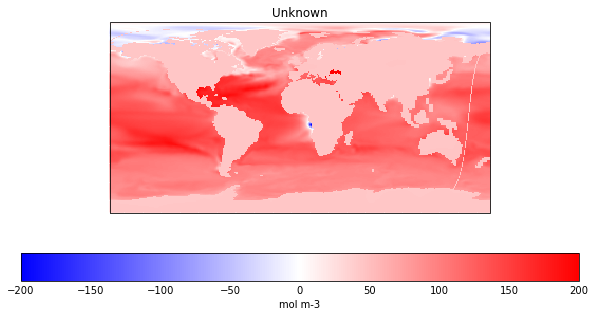

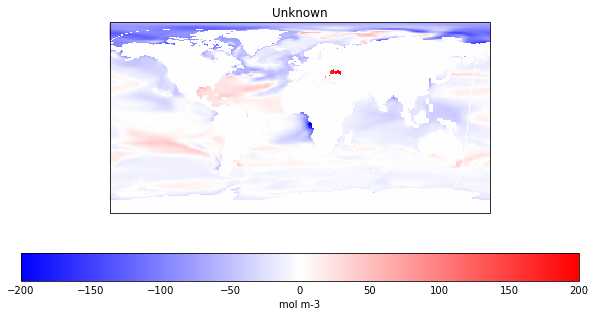

In [104]:
# cubes[model]['DIC_from_fCO2_all_change']
# cubes[model]['DIC_from_fCO2_just_alk']

to_plot = cubes[model]['DIC_from_fCO2_all_change']
plt.figure(figsize=(10,5))
to_plot2 = to_plot[-20::].collapsed('time',iris.analysis.MEAN) - to_plot[0:20].collapsed('time',iris.analysis.MEAN)
qplt.pcolormesh(to_plot2,cmap='bwr',vmin=-200,vmax=200)

to_plot = cubes[model]['DIC_from_fCO2_just_alk']
plt.figure(figsize=(10,5))
to_plot2 = to_plot[-20::].collapsed('time',iris.analysis.MEAN) - to_plot[0:20].collapsed('time',iris.analysis.MEAN)
qplt.pcolormesh(to_plot2,cmap='bwr',vmin=-200,vmax=200)

## Ratio of absolute alkalinity-only driven DIC change over absolute modelled DIC change

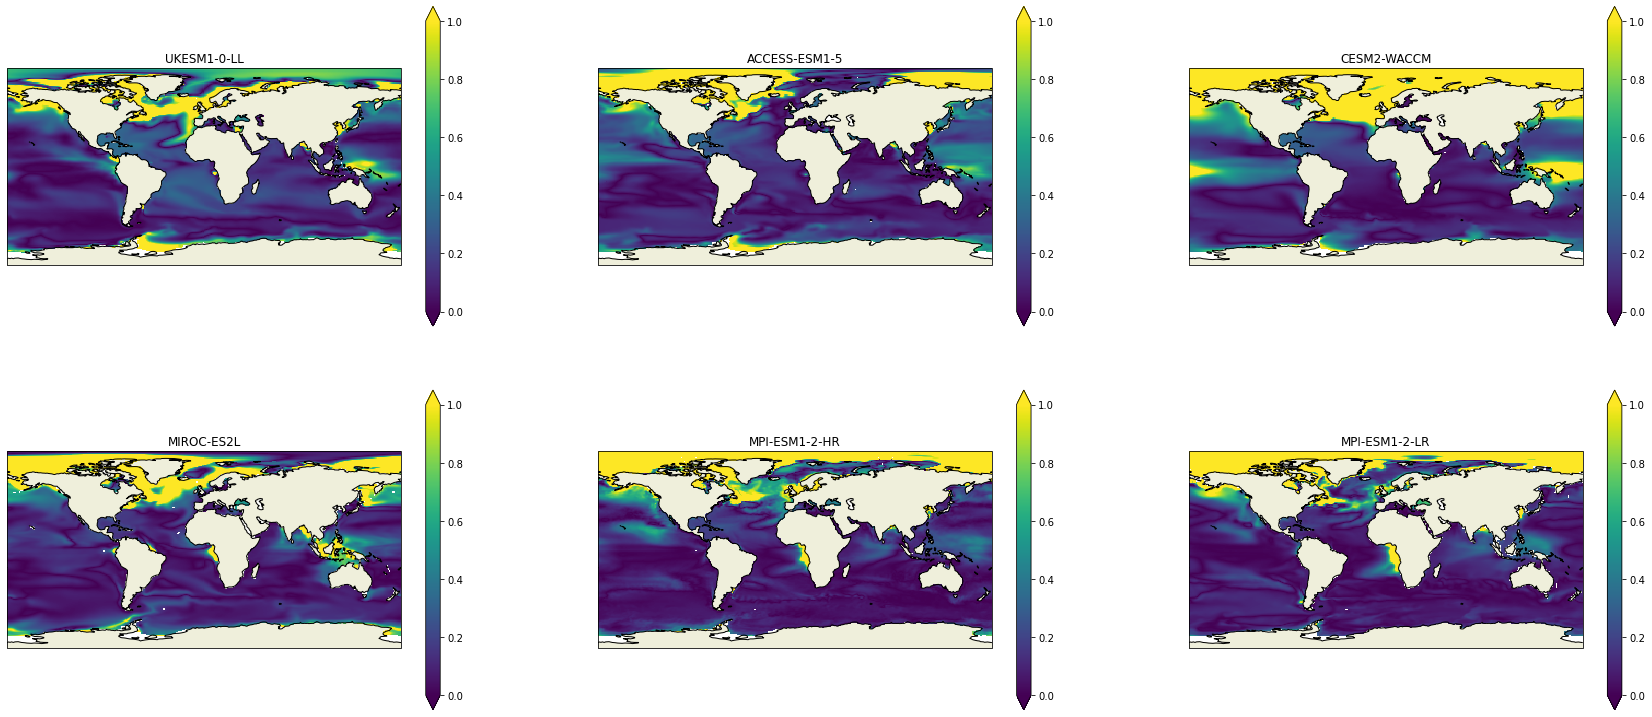

In [160]:

def mask_cube(cube,cube_with_mask):
    cube.data = np.ma.masked_where(cube_with_mask.data == np.nan,cube.data)
    cube.data.mask = np.logical_not((np.isfinite(cube_with_mask.data))).data
    return cube

plt.figure(figsize=(30,20))


for i,model in enumerate(models):
    ax = plt.subplot(3, 3, i+1, projection=ccrs.PlateCarree())

    to_plot = cubes[model]['DIC_from_fCO2_all_change']
#     to_plot = cubes[model]['DIC_from_fCO2_just_atmCO2_change']
    to_plot2 = iris.analysis.maths.abs(to_plot[-20::].collapsed('time',iris.analysis.MEAN) - to_plot[0:20].collapsed('time',iris.analysis.MEAN))

    to_plot = cubes[model]['DIC_from_fCO2_just_alk']
    to_plot2b = iris.analysis.maths.abs(to_plot[-20::].collapsed('time',iris.analysis.MEAN) - to_plot[0:20].collapsed('time',iris.analysis.MEAN))

    ratio_cube = to_plot2b/to_plot2
    ratio_cube = mask_cube(ratio_cube,cubes[model]['DIC_from_fCO2_just_alk'][0])


#     ax = plt.axes(projection=ccrs.PlateCarree())

    data = ratio_cube.data
    data[np.where(data == 0.0)] = np.nan
    lats = ratio_cube.coord('latitude').points
    lons = ratio_cube.coord('longitude').points
    C = ax.pcolormesh(lons,lats,data,cmap='viridis',vmin=0.0,vmax=1.0)
    ax.add_feature(cfeature.COASTLINE)
    ax.add_feature(cfeature.LAND)
    ax.set_title(model)
    plt.colorbar(C,extend = "both")


In [157]:
list(cubes[model])

['tos',
 'sos',
 'dissic',
 'talk',
 'spco2',
 'tas',
 'psl',
 'DIC_from_fCO2_all_change',
 'DIC_from_fCO2_just_alk',
 'DIC_from_fCO2_just_alk_and_sal',
 'DIC_from_fCO2_just_temp']

In [189]:
# https://pyco2sys.readthedocs.io/en/latest/co2sys_nd/#arguments
par1type = 1  # The first parameter supplied is of type "1", which is "alkalinity"
par1 = c_talk_data * 1.0e3  # value of the first parameter
par2type = 4  # The first parameter supplied is of type "1", which is "DIC"
par2 = c_spco2_data * Pa_to_uatm
# ^ value of the second parameter, which is a long vector of different DIC's!
sal = c_sos_data# Salinity of the sample
tempin = c_tos_data  # Temperature at input conditions
presin = 0  # Pressure    at input conditions
tempout = 0  # Temperature at output conditions - doesn't matter in this example
presout = 0  # Pressure    at output conditions - doesn't matter in this example
sil = 0  # Concentration of silicate  in the sample (in umol/kg)
po4 = 0  # Concentration of phosphate in the sample (in umol/kg)
pHscale = 1  # pH scale at which the input pH is reported ("1" means "Total Scale")  - doesn't matter in this example
k1k2c = 4  # Choice of H2CO3 and HCO3- dissociation constants K1 and K2 ("4" means "Mehrbach refit")
kso4c = 1  # Choice of HSO4- dissociation constants KSO4 ("1" means "Dickson")

# Do the calculation. See CO2SYS's help for syntax and output format
CO2dicta = CO2SYS(par1,par2,par1type,par2type,sal,tempin,tempout,presin,presout,sil,po4,pHscale,k1k2c,kso4c)

Some input pH values are impossibly high given the input alkalinity;
returning np.nan rather than negative DIC values.
Some input pH values are impossibly high given the input alkalinity;
returning np.nan rather than negative DIC values.
Some input pH values are impossibly high given the input alkalinity;
returning np.nan rather than negative DIC values.
Some input pH values are impossibly high given the input alkalinity;
returning np.nan rather than negative DIC values.


/Users/ph290/miniconda2/envs/mypython3/lib/python3.8/site-packages/PyCO2SYS/buffers/__init__.py:67: RuntimeWarning: divide by zero encountered in true_divide
  return dTA_dPH__FC / dTC_dPH__FC


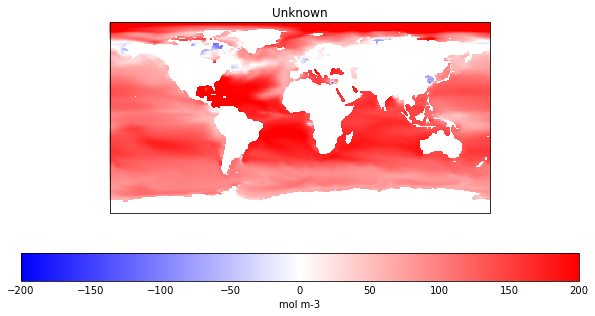

In [202]:
c_dissic_data_outa = np.reshape(CO2dicta['TCO2'],np.shape(c_talk_data))
c_dissic_outa = c_dissic.copy()
c_dissic_outa.data = c_dissic_data_outa

plt.figure(figsize=(10,5))
DIC_change_all_factors_seawater_pco2 = c_dissic_outa[-20::].collapsed('time',iris.analysis.MEAN) - c_dissic_outa[0:20].collapsed('time',iris.analysis.MEAN)
qplt.pcolormesh(DIC_change_all_factors_seawater_pco2,cmap='bwr',vmin=-200,vmax=200)

## Keeping pCO2 and T at level of climatology from 1st 20 years

In [192]:
c_spco2_data_init_climatology_repeat = np.tile(np.mean(c_spco2_data[0:20,:,:],axis=0), (np.shape(c_spco2_data)[0],1,1))
c_tos_data_init_climatology_repeat = np.tile(np.mean(c_tos_data[0:20,:,:],axis=0), (np.shape(c_tos_data)[0],1,1))

# https://pyco2sys.readthedocs.io/en/latest/co2sys_nd/#arguments
par1type = 1  # The first parameter supplied is of type "1", which is "alkalinity"
par1 = c_talk_data * 1.0e3  # value of the first parameter
par2type = 4  # The first parameter supplied is of type "1", which is "DIC"
par2 = c_spco2_data_init_climatology_repeat * Pa_to_uatm
# ^ value of the second parameter, which is a long vector of different DIC's!
sal = c_sos_data # Salinity of the sample
tempin = c_tos_data_init_climatology_repeat  # Temperature at input conditions
presin = 0  # Pressure    at input conditions
tempout = 0  # Temperature at output conditions - doesn't matter in this example
presout = 0  # Pressure    at output conditions - doesn't matter in this example
sil = 0  # Concentration of silicate  in the sample (in umol/kg)
po4 = 0  # Concentration of phosphate in the sample (in umol/kg)
pHscale = 1  # pH scale at which the input pH is reported ("1" means "Total Scale")  - doesn't matter in this example
k1k2c = 4  # Choice of H2CO3 and HCO3- dissociation constants K1 and K2 ("4" means "Mehrbach refit")
kso4c = 1  # Choice of HSO4- dissociation constants KSO4 ("1" means "Dickson")

# Do the calculation. See CO2SYS's help for syntax and output format
CO2dict2a = CO2SYS(par1,par2,par1type,par2type,sal,tempin,tempout,presin,presout,sil,po4,pHscale,k1k2c,kso4c)

Some input pH values are impossibly high given the input alkalinity;
returning np.nan rather than negative DIC values.
Some input pH values are impossibly high given the input alkalinity;
returning np.nan rather than negative DIC values.
Some input pH values are impossibly high given the input alkalinity;
returning np.nan rather than negative DIC values.
Some input pH values are impossibly high given the input alkalinity;
returning np.nan rather than negative DIC values.


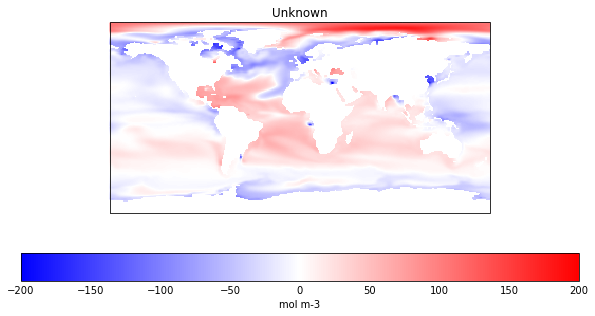

In [201]:
c_dissic_data_out2a = np.reshape(CO2dict2a['TCO2'],np.shape(c_talk_data))
c_dissic_out2a = c_dissic.copy()
c_dissic_out2a.data = c_dissic_data_out2a

plt.figure(figsize=(10,5))
DIC_change_just_alk_and_sal_change_seawater_pCO2 = c_dissic_out2a[-20::].collapsed('time',iris.analysis.MEAN) - c_dissic_out2a[0:20].collapsed('time',iris.analysis.MEAN)
qplt.pcolormesh(DIC_change_just_alk_and_sal_change_seawater_pCO2,cmap='bwr',vmin=-200,vmax=200)

note [FURTHER NOTE - results below disprove this] - big increase in arctic is presumably because the CO2 can get in - this is 'cos I'm using pCO2 in seawater whereas I would probably be better off using a gaseous CO2 to find out what would be in equilibrium with that water

## So below, I'm doing this based on fCO2 calculated from atmospheric CO2

In [139]:


xCO2 = total_atm_co2_mass_to_ppmv(c_co2mass_data)
fCO2 = fugacity_of_CO2_in_air(c_tas_data,c_psl_data,xCO2)

In [141]:
# https://pyco2sys.readthedocs.io/en/latest/co2sys_nd/#arguments
par1type = 1  # The first parameter supplied is of type "1", which is "alkalinity"
par1 = c_talk_data * 1.0e3  # value of the first parameter
par2type = 5  # The first parameter supplied is of type "1", which is "DIC"
par2 = fCO2 # uatm
# ^ value of the second parameter, which is a long vector of different DIC's!
sal = c_sos_data# Salinity of the sample
tempin = c_tos_data  # Temperature at input conditions
presin = 0  # Pressure    at input conditions
tempout = 0  # Temperature at output conditions - doesn't matter in this example
presout = 0  # Pressure    at output conditions - doesn't matter in this example
sil = 0  # Concentration of silicate  in the sample (in umol/kg)
po4 = 0  # Concentration of phosphate in the sample (in umol/kg)
pHscale = 1  # pH scale at which the input pH is reported ("1" means "Total Scale")  - doesn't matter in this example
k1k2c = 4  # Choice of H2CO3 and HCO3- dissociation constants K1 and K2 ("4" means "Mehrbach refit")
kso4c = 1  # Choice of HSO4- dissociation constants KSO4 ("1" means "Dickson")

# Do the calculation. See CO2SYS's help for syntax and output format
CO2dict = CO2SYS(par1,par2,par1type,par2type,sal,tempin,tempout,presin,presout,sil,po4,pHscale,k1k2c,kso4c)

/Users/ph290/miniconda2/envs/mypython3/lib/python3.8/site-packages/PyCO2SYS/solve/initialise.py:15: RuntimeWarning: divide by zero encountered in true_divide
  c2 = KB - (TB * KB + K1 * CO2) / CBAlk
/Users/ph290/miniconda2/envs/mypython3/lib/python3.8/site-packages/PyCO2SYS/solve/initialise.py:16: RuntimeWarning: divide by zero encountered in true_divide
  c1 = -K1 * (2 * K2 * CO2 + KB * CO2) / CBAlk
/Users/ph290/miniconda2/envs/mypython3/lib/python3.8/site-packages/PyCO2SYS/solve/initialise.py:17: RuntimeWarning: divide by zero encountered in true_divide
  c0 = -2 * K1 * K2 * KB * CO2 / CBAlk


In [198]:
c_dissic_data_out = np.reshape(CO2dict['TCO2'],np.shape(c_talk_data))
c_dissic_out = c_dissic.copy()
c_dissic_out.data = c_dissic_data_out



In [146]:
c_fCO2_data_init_climatology_repeat = np.tile(np.mean(fCO2[0:20,:,:],axis=0), (np.shape(fCO2)[0],1,1))
c_tos_data_init_climatology_repeat = np.tile(np.mean(c_tos_data[0:20,:,:],axis=0), (np.shape(c_tos_data)[0],1,1))

# https://pyco2sys.readthedocs.io/en/latest/co2sys_nd/#arguments
par1type = 1  # The first parameter supplied is of type "1", which is "alkalinity"
par1 = c_talk_data * 1.0e3  # value of the first parameter
par2type = 5  # The first parameter supplied is of type "1", which is "DIC"
par2 = c_fCO2_data_init_climatology_repeat
# ^ value of the second parameter, which is a long vector of different DIC's!
sal = c_sos_data # Salinity of the sample
tempin = c_tos_data_init_climatology_repeat  # Temperature at input conditions
presin = 0  # Pressure    at input conditions
tempout = 0  # Temperature at output conditions - doesn't matter in this example
presout = 0  # Pressure    at output conditions - doesn't matter in this example
sil = 0  # Concentration of silicate  in the sample (in umol/kg)
po4 = 0  # Concentration of phosphate in the sample (in umol/kg)
pHscale = 1  # pH scale at which the input pH is reported ("1" means "Total Scale")  - doesn't matter in this example
k1k2c = 4  # Choice of H2CO3 and HCO3- dissociation constants K1 and K2 ("4" means "Mehrbach refit")
kso4c = 1  # Choice of HSO4- dissociation constants KSO4 ("1" means "Dickson")

# Do the calculation. See CO2SYS's help for syntax and output format
CO2dict2 = CO2SYS(par1,par2,par1type,par2type,sal,tempin,tempout,presin,presout,sil,po4,pHscale,k1k2c,kso4c)

In [196]:
c_dissic_data_out2 = np.reshape(CO2dict2['TCO2'],np.shape(c_talk_data))
c_dissic_out2 = c_dissic.copy()
c_dissic_out2.data = c_dissic_data_out2
# qplt.pcolormesh(c_dissic_out2[0],vmin=1800,vmax=2300)



In [264]:
c_tos_data_init_climatology_repeat = np.tile(np.mean(c_tos_data[0:20,:,:],axis=0), (np.shape(c_tos_data)[0],1,1))
c_sos_data_init_climatology_repeat = np.tile(np.mean(c_sos_data[0:20,:,:],axis=0), (np.shape(c_sos_data)[0],1,1))
c_c_talk_data_data_init_climatology_repeat = np.tile(np.mean(c_talk_data[0:20,:,:],axis=0), (np.shape(c_talk_data)[0],1,1))

# https://pyco2sys.readthedocs.io/en/latest/co2sys_nd/#arguments
par1type = 1  # The first parameter supplied is of type "1", which is "alkalinity"
par1 = c_c_talk_data_data_init_climatology_repeat * 1.0e3  # value of the first parameter
par2type = 5  # The first parameter supplied is of type "1", which is "DIC"
par2 = fCO2
# ^ value of the second parameter, which is a long vector of different DIC's!
sal = c_sos_data_init_climatology_repeat # Salinity of the sample
tempin = c_tos_data_init_climatology_repeat  # Temperature at input conditions
presin = 0  # Pressure    at input conditions
tempout = 0  # Temperature at output conditions - doesn't matter in this example
presout = 0  # Pressure    at output conditions - doesn't matter in this example
sil = 0  # Concentration of silicate  in the sample (in umol/kg)
po4 = 0  # Concentration of phosphate in the sample (in umol/kg)
pHscale = 1  # pH scale at which the input pH is reported ("1" means "Total Scale")  - doesn't matter in this example
k1k2c = 4  # Choice of H2CO3 and HCO3- dissociation constants K1 and K2 ("4" means "Mehrbach refit")
kso4c = 1  # Choice of HSO4- dissociation constants KSO4 ("1" means "Dickson")

# Do the calculation. See CO2SYS's help for syntax and output format
CO2dict3 = CO2SYS(par1,par2,par1type,par2type,sal,tempin,tempout,presin,presout,sil,po4,pHscale,k1k2c,kso4c)

In [265]:
c_dissic_data_out3 = np.reshape(CO2dict3['TCO2'],np.shape(c_talk_data))
c_dissic_out3 = c_dissic.copy()
c_dissic_out3.data = c_dissic_data_out3
# qplt.pcolormesh(c_dissic_out2[0],vmin=1800,vmax=2300)


In [268]:
c_sos_data_init_climatology_repeat = np.tile(np.mean(c_sos_data[0:20,:,:],axis=0), (np.shape(c_sos_data)[0],1,1))
c_c_talk_data_data_init_climatology_repeat = np.tile(np.mean(c_talk_data[0:20,:,:],axis=0), (np.shape(c_talk_data)[0],1,1))

# https://pyco2sys.readthedocs.io/en/latest/co2sys_nd/#arguments
par1type = 1  # The first parameter supplied is of type "1", which is "alkalinity"
par1 = c_c_talk_data_data_init_climatology_repeat * 1.0e3  # value of the first parameter
par2type = 5  # The first parameter supplied is of type "1", which is "DIC"
par2 = fCO2
# ^ value of the second parameter, which is a long vector of different DIC's!
sal = c_sos_data_init_climatology_repeat # Salinity of the sample
tempin = c_tos_data  # Temperature at input conditions
presin = 0  # Pressure    at input conditions
tempout = 0  # Temperature at output conditions - doesn't matter in this example
presout = 0  # Pressure    at output conditions - doesn't matter in this example
sil = 0  # Concentration of silicate  in the sample (in umol/kg)
po4 = 0  # Concentration of phosphate in the sample (in umol/kg)
pHscale = 1  # pH scale at which the input pH is reported ("1" means "Total Scale")  - doesn't matter in this example
k1k2c = 4  # Choice of H2CO3 and HCO3- dissociation constants K1 and K2 ("4" means "Mehrbach refit")
kso4c = 1  # Choice of HSO4- dissociation constants KSO4 ("1" means "Dickson")

# Do the calculation. See CO2SYS's help for syntax and output format
CO2dict4 = CO2SYS(par1,par2,par1type,par2type,sal,tempin,tempout,presin,presout,sil,po4,pHscale,k1k2c,kso4c)

In [269]:
c_dissic_data_out4 = np.reshape(CO2dict4['TCO2'],np.shape(c_talk_data))
c_dissic_out4 = c_dissic.copy()
c_dissic_out4.data = c_dissic_data_out4
# qplt.pcolormesh(c_dissic_out2[0],vmin=1800,vmax=2300)


## 21stC story

The 21stC DIC change under SSP5-8.5 has considerable spatial variability, with the areas of weakest DIC growth corresponding to important carbon sink regions.

The plot below shows the UKESMs 2080-2100 mean minus the 2015-2035 mean

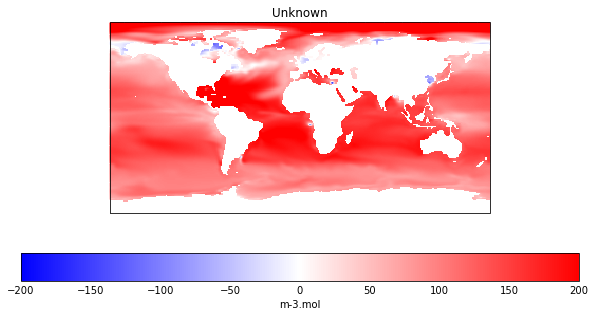

In [185]:
plt.figure(figsize=(10,5))
change_in_model_dissic = (c_dissic[-20::].collapsed('time',iris.analysis.MEAN) - c_dissic[0:20].collapsed('time',iris.analysis.MEAN))*1000.0
qplt.pcolormesh(change_in_model_dissic,cmap='bwr',vmin=-200,vmax=200)

The next plot is the DIC change recalculated from model pCO2, alk, T and S 

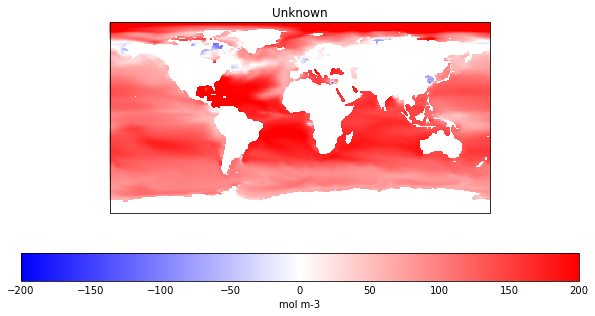

In [203]:
plt.figure(figsize=(10,5))
DIC_change_all_factors_seawater_pco2 = c_dissic_outa[-20::].collapsed('time',iris.analysis.MEAN) - c_dissic_outa[0:20].collapsed('time',iris.analysis.MEAN)
qplt.pcolormesh(DIC_change_all_factors_seawater_pco2,cmap='bwr',vmin=-200,vmax=200)

One could suggest that this pattern occurs because DIC is removed form the surface in these regions BUT...

...we can replicate this pattern when calculating the DIC in equilibrium with the time-varying atm. CO2 when just temperature, salinity and alkalinity are changing.



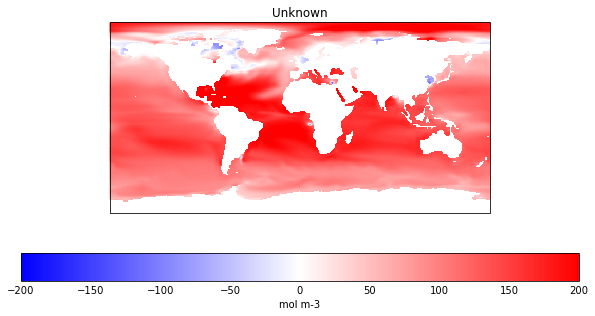

In [247]:
plt.figure(figsize=(10,5))
DIC_change_all_factors = c_dissic_out[-20::].collapsed('time',iris.analysis.MEAN) - c_dissic_out[0:20].collapsed('time',iris.analysis.MEAN)
DIC_change_all_factors.data = np.ma.masked_where(DIC_change_all_factors_seawater_pco2.data == np.nan,DIC_change_all_factors.data)
DIC_change_all_factors.data.mask = np.logical_not((np.isfinite(DIC_change_all_factors_seawater_pco2.data))).data
qplt.pcolormesh(DIC_change_all_factors,cmap='bwr',vmin=-200,vmax=200)

We can then ask what the DIC change would look like if only alkalinity and salinity were changing, and we see that this basically explains the spatial structure

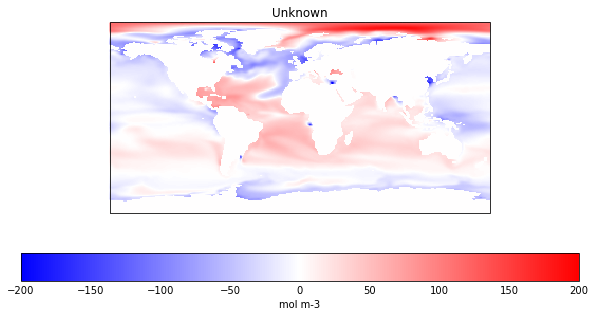

In [187]:
plt.figure(figsize=(10,5))
DIC_change_just_alk_and_sal_change = c_dissic_out2[-20::].collapsed('time',iris.analysis.MEAN) - c_dissic_out2[0:20].collapsed('time',iris.analysis.MEAN)
qplt.pcolormesh(DIC_change_just_alk_and_sal_change,cmap='bwr',vmin=-200,vmax=200)

Interestingly, if we take the alklainity driven change away from the all-factors change, alkalinity is essentially responsable for the high uptake in the Arctic, which is not what I would have epxected! Need to look into this, but perhaps just a model specific rebound from the sudden drop in uptake before/early-in the 21stC, which negates much DIC uptake at that time.

Below, DIC change from model DIC minus what you woudl expect if atm CO2 was the only think changing - does it look like the above?

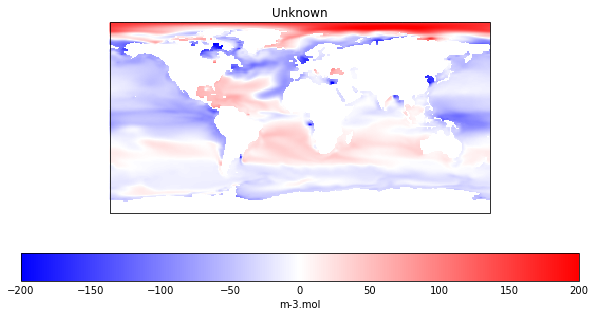

In [266]:

DIC_change_just_atm_co2 = c_dissic_out3[-20::].collapsed('time',iris.analysis.MEAN) - c_dissic_out3[0:20].collapsed('time',iris.analysis.MEAN)
DIC_change_just_atm_co2.data.mask = np.logical_not((np.isfinite(DIC_change_all_factors_seawater_pco2.data))).data

plt.figure(figsize=(10,5))
qplt.pcolormesh(change_in_model_dissic - DIC_change_just_atm_co2,cmap='bwr',vmin=-200,vmax=200)

Change just due to rusing atm. CO2

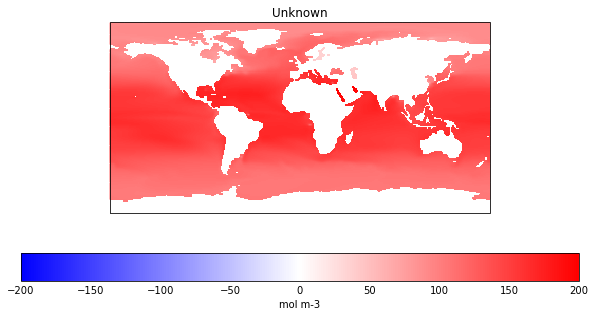

In [267]:
plt.figure(figsize=(10,5))
qplt.pcolormesh(DIC_change_just_atm_co2,cmap='bwr',vmin=-200,vmax=200)

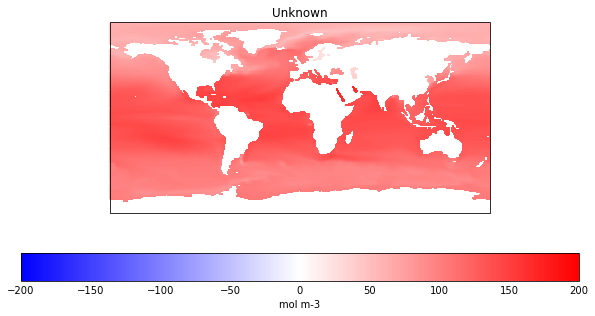

In [270]:
DIC_change_just_atm_co2_and_T = c_dissic_out4[-20::].collapsed('time',iris.analysis.MEAN) - c_dissic_out4[0:20].collapsed('time',iris.analysis.MEAN)
DIC_change_just_atm_co2_and_T.data.mask = np.logical_not((np.isfinite(DIC_change_all_factors_seawater_pco2.data))).data

plt.figure(figsize=(10,5))
qplt.pcolormesh(DIC_change_just_atm_co2_and_T,cmap='bwr',vmin=-200,vmax=200)

Below, DIC change die to all factors, minus that occuring just in response to the alk and sal change

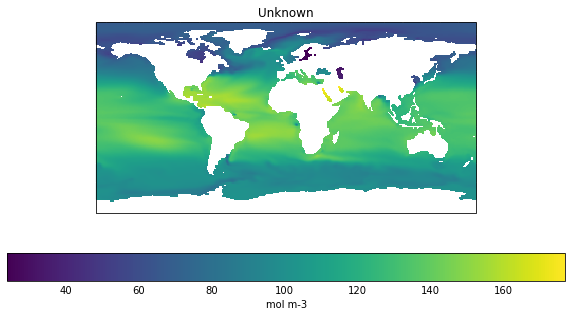

In [249]:
plt.figure(figsize=(10,5))

DIC_change_all_factors.data.mask = np.logical_not((np.isfinite(DIC_change_all_factors_seawater_pco2.data))).data
DIC_change_just_alk_and_sal_change.data.mask = np.logical_not((np.isfinite(DIC_change_all_factors_seawater_pco2.data))).data

qplt.pcolormesh(DIC_change_all_factors - DIC_change_just_alk_and_sal_change)

An important conclusion from all of this is that the major sink regions (N. Atl. and S. Ocean) actually have pretty small DIC increases over the 21stC because of the (freshening?) driven alkalnity changes

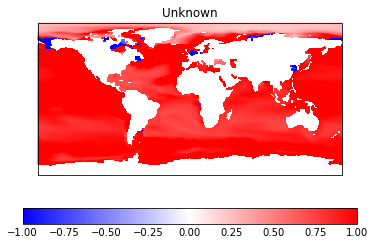

In [262]:
qplt.pcolormesh((DIC_change_all_factors - DIC_change_just_alk_and_sal_change)/change_in_model_dissic,cmap='bwr',vmin=-1,vmax=1)

In [263]:
160/200

0.8

## omega Calcite

[CO3] response to 21stC change in all variables

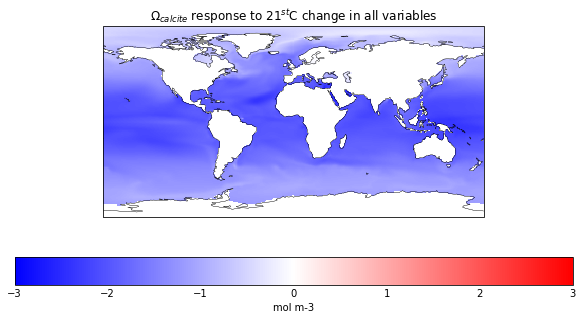

In [322]:
variable = 'OmegaCAout'
# variable = 'CO3out'
c_CO3_data_out = np.reshape(CO2dict[variable],np.shape(c_talk_data))
c_CO3_out = c_dissic.copy()
c_CO3_out.data = c_CO3_data_out

CO3_change_atm_co2_and_temp = c_CO3_out[-20::].collapsed('time',iris.analysis.MEAN) - c_CO3_out[0:20].collapsed('time',iris.analysis.MEAN)
CO3_change_atm_co2_and_temp.data.mask = np.logical_not((np.isfinite(DIC_change_all_factors_seawater_pco2.data))).data

plt.figure(figsize=(10,5))
qplt.pcolormesh(CO3_change_atm_co2_and_temp,cmap='bwr',vmin=-3,vmax=3)
plt.title('$\Omega_{calcite}$ response to 21$^{st}$C change in all variables')
plt.gca().coastlines(lw=0.25)
plt.savefig('/Users/ph290/Downloads/OA_all_vars.png',dpi=600)
plt.gca().coastlines(lw=0.25)

[CO3] response to 21stC increase in atm. CO2 and temperature

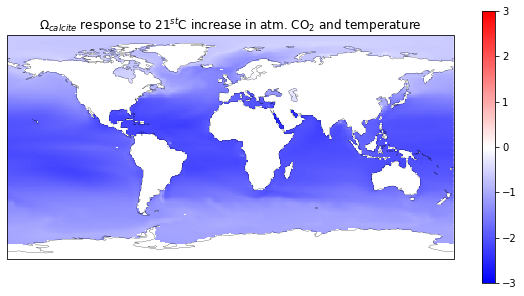

In [320]:
variable = 'OmegaCAout'
# variable = 'CO3out'
c_CO3_data_out = np.reshape(CO2dict4[variable],np.shape(c_talk_data))
c_CO3_out = c_dissic.copy()
c_CO3_out.data = c_CO3_data_out

CO3_change_atm_co2_and_temp = c_CO3_out[-20::].collapsed('time',iris.analysis.MEAN) - c_CO3_out[0:20].collapsed('time',iris.analysis.MEAN)
CO3_change_atm_co2_and_temp.data.mask = np.logical_not((np.isfinite(DIC_change_all_factors_seawater_pco2.data))).data

plt.figure(figsize=(10,5))
iplt.pcolormesh(CO3_change_atm_co2_and_temp,cmap='bwr',vmin=-3,vmax=3)
plt.colorbar()
plt.title('$\Omega_{calcite}$ response to 21$^{st}$C increase in atm. CO$_2$ and temperature')
plt.gca().coastlines(lw=0.25)
plt.savefig('/Users/ph290/Downloads/OA_CO2nT.png',dpi=600)

[CO3] response to 21stC change in alkalinity and salinity

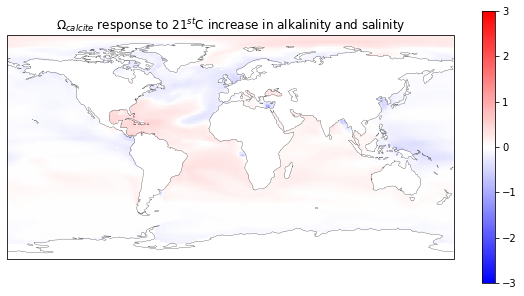

In [319]:
variable = 'OmegaCAout'
# variable = 'CO3out'
c_CO3_data_out = np.reshape(CO2dict2[variable],np.shape(c_talk_data))
c_CO3_out = c_dissic.copy()
c_CO3_out.data = c_CO3_data_out

CO3_change_alk_and_sal = c_CO3_out[-20::].collapsed('time',iris.analysis.MEAN) - c_CO3_out[0:20].collapsed('time',iris.analysis.MEAN)
CO3_change_alk_and_sal.data.mask = np.logical_not((np.isfinite(DIC_change_all_factors_seawater_pco2.data))).data

plt.figure(figsize=(10,5))
iplt.pcolormesh(CO3_change_alk_and_sal,cmap='bwr',vmin=-3,vmax=3)
plt.colorbar()
plt.title('$\Omega_{calcite}$ response to 21$^{st}$C increase in alkalinity and salinity')
plt.gca().coastlines(lw=0.25)
plt.savefig('/Users/ph290/Downloads/OA_talk.png',dpi=600)

In [293]:
list(CO2dict2)

['TAlk',
 'TCO2',
 'pHin',
 'pCO2in',
 'fCO2in',
 'HCO3in',
 'CO3in',
 'CO2in',
 'BAlkin',
 'OHin',
 'PAlkin',
 'SiAlkin',
 'NH3Alkin',
 'H2SAlkin',
 'Hfreein',
 'RFin',
 'OmegaCAin',
 'OmegaARin',
 'xCO2in',
 'pHout',
 'pCO2out',
 'fCO2out',
 'HCO3out',
 'CO3out',
 'CO2out',
 'BAlkout',
 'OHout',
 'PAlkout',
 'SiAlkout',
 'NH3Alkout',
 'H2SAlkout',
 'Hfreeout',
 'RFout',
 'OmegaCAout',
 'OmegaARout',
 'xCO2out',
 'pHinTOTAL',
 'pHinSWS',
 'pHinFREE',
 'pHinNBS',
 'pHoutTOTAL',
 'pHoutSWS',
 'pHoutFREE',
 'pHoutNBS',
 'TEMPIN',
 'TEMPOUT',
 'PRESIN',
 'PRESOUT',
 'SAL',
 'PO4',
 'SI',
 'NH3',
 'H2S',
 'K0input',
 'K1input',
 'K2input',
 'pK1input',
 'pK2input',
 'KWinput',
 'KBinput',
 'KFinput',
 'KSinput',
 'KP1input',
 'KP2input',
 'KP3input',
 'KSiinput',
 'KNH3input',
 'KH2Sinput',
 'K0output',
 'K1output',
 'K2output',
 'pK1output',
 'pK2output',
 'KWoutput',
 'KBoutput',
 'KFoutput',
 'KSoutput',
 'KP1output',
 'KP2output',
 'KP3output',
 'KSioutput',
 'KNH3output',
 'KH2Soutput